In [1]:
from langgraph.graph import StateGraph

# stategraph 接收一个字典
builder = StateGraph(dict)

In [2]:
builder

In [4]:
builder.schemas

{dict: {'__root__': <langgraph.channels.last_value.LastValue at 0x163d0a5aac0>}}

In [5]:
def addition(state):
    print(f"init_state: {state}")
    return {"x": state["x"] + 1}


def subtraction(state):
    print(f"addition_state: {state}")
    return {"x": state["x"] - 2}

In [6]:
# START 和 END 是两个特殊节点
from langgraph.graph import START, END

# 添加节点
builder.add_node("addition", addition)
builder.add_node("subtraction", subtraction)

# 构建边
builder.add_edge(START, "addition")
builder.add_edge("addition", "subtraction")
builder.add_edge("subtraction", END)

In [7]:
builder.edges

{('__start__', 'addition'),
 ('addition', 'subtraction'),
 ('subtraction', '__end__')}

In [8]:
builder.nodes

{'addition': StateNodeSpec(runnable=addition(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class 'dict'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'subtraction': StateNodeSpec(runnable=subtraction(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class 'dict'>, retry_policy=None, cache_policy=None, ends=(), defer=False)}

In [9]:
graph = builder.compile()

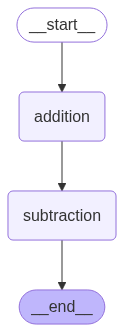

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [11]:
init_state = {"x": 10}

graph.invoke(init_state)

init_state: {'x': 10}
addition_state: {'x': 11}


{'x': 9}

In [1]:
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END


class CalcState(BaseModel):
    x: int


def addition(state: CalcState) -> CalcState:
    print(f"[addition] 初始状态: {state}")
    return CalcState(x=state.x + 1)


def subtraction(state: CalcState) -> CalcState:
    print(f"[subtraction] 接受到状态: {state}")
    return CalcState(x=state.x - 2)


builder = StateGraph(CalcState)

builder.add_node("addition", addition)
builder.add_node("subtraction", subtraction)

builder.add_edge(START, "addition")
builder.add_edge("addition", "subtraction")
builder.add_edge("subtraction", END)

graph = builder.compile()

initial_state = CalcState(x=10)
final_state = graph.invoke(initial_state)

print(final_state)

[addition] 初始状态: x=10
[subtraction] 接受到状态: x=11
{'x': 9}


## 条件分支图

In [4]:
from pydantic import BaseModel
from typing import Optional
from langgraph.graph import StateGraph, START, END


class MyState(BaseModel):
    x: int
    result: Optional[str] = None


def check_x(state: MyState) -> MyState:
    print(f"[check_x] Received state: {state}")
    return state


def is_even(state: MyState) -> bool:
    return state.x % 2 == 0


def handle_even(state: MyState) -> MyState:
    print("[handle_even] x 是偶数")
    return MyState(x=state.x, result="even")


def handle_odd(state: MyState) -> MyState:
    print("[handle_odd] x 是奇数")
    return MyState(x=state.x, result="odd")


builder = StateGraph(MyState)

builder.add_node(check_x)
builder.add_node(handle_even)
builder.add_node(handle_odd)

# 添加条件分支
builder.add_conditional_edges(
    "check_x",
    is_even,
    {
        True: "handle_even",
        False: "handle_odd",
    },
)

builder.add_edge(START, "check_x")
builder.add_edge("handle_even", END)
builder.add_edge("handle_odd", END)

graph = builder.compile()

print("测试 x=4")
graph.invoke(MyState(x=4))

print("测试 x=3")
graph.invoke(MyState(x=3))

测试 x=4
[check_x] Received state: x=4 result=None
[handle_even] x 是偶数
测试 x=3
[check_x] Received state: x=3 result=None
[handle_odd] x 是奇数


{'x': 3, 'result': 'odd'}

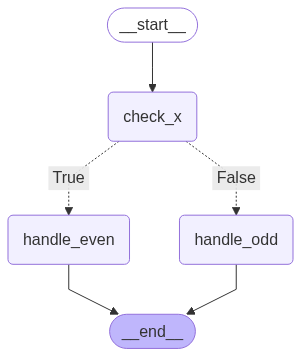

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## 条件循环图

In [6]:
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END


# ✅ 1. 定义结构化状态模型
class LoopState(BaseModel):
    x: int


# ✅ 2. 定义节点逻辑
def increment(state: LoopState) -> LoopState:
    print(f"[increment] 当前 x = {state.x}")
    return LoopState(x=state.x + 1)


def is_done(state: LoopState) -> bool:
    return state.x > 10


# ✅ 3. 构建图
builder = StateGraph(LoopState)
builder.add_node("increment", increment)

# ✅ 4. 设置循环控制：is_done 为 True 则结束，否则继续
builder.add_conditional_edges("increment", is_done, {True: END, False: "increment"})

builder.add_edge(START, "increment")
graph = builder.compile()

# ✅ 5. 测试执行
print("\n✅ 执行循环直到 x > 10")
final_state = graph.invoke(LoopState(x=6))
print(f"[最终结果] -> x = {final_state['x']}")


✅ 执行循环直到 x > 10
[increment] 当前 x = 6
[increment] 当前 x = 7
[increment] 当前 x = 8
[increment] 当前 x = 9
[increment] 当前 x = 10
[最终结果] -> x = 11


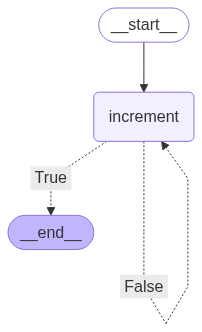

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Graph 构建多轮对话机器人

In [9]:
from typing import Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [10]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
import os

load_dotenv(override=True)

model = init_chat_model(
    model="deepseek-v3",
    model_provider="openai",
    api_key=os.environ["DASHSCOPE_API_KEY"],
    base_url=os.environ["BASE_URL"],
)

In [11]:
def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"])]}

In [12]:
from langgraph.graph import START

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

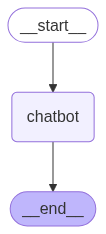

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
final_state = graph.invoke({"messages": ["你好，我叫bo，好久不见"]})
final_state

{'messages': [HumanMessage(content='你好，我叫bo，好久不见', additional_kwargs={}, response_metadata={}, id='27281f91-da70-43d9-9fac-0c3bd1cf5db5'),
  AIMessage(content='你好呀Bo！确实好久不见～最近过得怎么样？有什么新鲜事想分享吗？或者需要帮忙的地方随时告诉我哦～ （如果这是重逢的玩笑，那我可要配合一下：“这么久没见，我的缓存里都找不到你上次的聊天记录了😄”）', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 10, 'total_tokens': 67, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'deepseek-v3', 'system_fingerprint': None, 'id': 'chatcmpl-b96cc111-ce33-97ef-8924-bf10a5032efc', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--6227cee4-b204-4b01-9a4c-0f8b7f6d6b6b-0', usage_metadata={'input_tokens': 10, 'output_tokens': 57, 'total_tokens': 67, 'input_token_details': {}, 'output_token_details': {}})]}

In [15]:
from langchain_core.messages import AIMessage, HumanMessage

messages_list = [
    HumanMessage(content="你好，我叫bo，好久不见"),
    AIMessage(
        content="你好呀Bo！确实好久不见～最近过得怎么样？有什么新鲜事想分享吗？或者需要帮忙的地方随时告诉我哦～ （如果这是重逢的玩笑，那我可要配合一下：“这么久没见，我的缓存里都找不到你上次的聊天记录了😄”）"
    ),
    HumanMessage(content="请问你还记得我叫什么名字吗？"),
]

final_state = graph.invoke({"messages": messages_list})
final_state

{'messages': [HumanMessage(content='你好，我叫bo，好久不见', additional_kwargs={}, response_metadata={}, id='e35585dc-0fd7-4013-abae-660976f9de88'),
  AIMessage(content='你好呀Bo！确实好久不见～最近过得怎么样？有什么新鲜事想分享吗？或者需要帮忙的地方随时告诉我哦～ （如果这是重逢的玩笑，那我可要配合一下：“这么久没见，我的缓存里都找不到你上次的聊天记录了😄”）', additional_kwargs={}, response_metadata={}, id='f034fcaa-a8f3-4208-8a6a-5d1b8ef7a061'),
  HumanMessage(content='请问你还记得我叫什么名字吗？', additional_kwargs={}, response_metadata={}, id='4be43663-43a7-43e3-bc79-c4d06330b11f'),
  AIMessage(content='哈哈，当然记得呀！你刚刚说过叫 **Bo** 嘛～ （如果这是考我的记忆力，放心，短期记忆还在线哦！😉）  \n不过悄悄说，作为AI，每次对话都是全新的开始，但只要你提到名字，我一定会认真记住当前聊天的上下文～ 需要我帮你记点什么特别的信息吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 78, 'total_tokens': 149, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'deepseek-v3', 'system_fingerprint': None, 'id': 'chatcmpl-16f0b0c0-acf0-9ddd-936f-e1ae3696f152', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': 

In [16]:
# 实现可交互的聊天机器人

messages_list = []
while True:
    try:
        user_input = input("用户提问：")
        if user_input.lower() in ["exit", "quit"]:
            print("下次再见！")
            break

        messages_list.append(HumanMessage(content=user_input))
        final_state = graph.invoke({"messages": messages_list})
        print("🤖 小智：", final_state["messages"][-1].content)
        messages_list.append(final_state["messages"][-1])
        messages_list = messages_list[-50:]
    except:  # noqa
        break

🤖 小智： 你好，Bo！很高兴认识你～ 😊 有什么我可以帮你的吗？或者想随便聊聊？
🤖 小智： 哈哈，你刚刚说过啦，你叫 **Bo**～ 😄 我记性还不错吧？（如果之前是开玩笑的，或者有另一个名字，随时告诉我哦！）  

有什么想聊的话题吗？✨
下次再见！


In [17]:
# MemorySaver
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

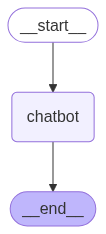

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
thread_config = {"configurable": {"thread_id": "session_10"}}

In [20]:
state1 = graph.invoke(
    {"messages": [{"role": "human", "content": "你好，好久不见，我叫bo"}]},
    config=thread_config,
)
state1

{'messages': [HumanMessage(content='你好，好久不见，我叫bo', additional_kwargs={}, response_metadata={}, id='799ef1a9-2ca8-4784-8334-12d641f3bf8a'),
  AIMessage(content='你好呀Bo！虽然我们可能是第一次“见面”，但很高兴认识你～ 😊 最近过得怎么样？有什么想聊的或者需要帮忙的吗？无论是分享新鲜事、讨论兴趣，还是有问题需要解答，我都在这里哦！ （对了，如果是熟人重逢的玩笑…那我配合演出一下：哇，真的好“久”不见！🤣）', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 10, 'total_tokens': 85, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'deepseek-v3', 'system_fingerprint': None, 'id': 'chatcmpl-83884374-4926-9d14-84b5-929a493294f4', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--74ef275b-b897-4c1b-96dc-fb3b31e9b661-0', usage_metadata={'input_tokens': 10, 'output_tokens': 75, 'total_tokens': 85, 'input_token_details': {}, 'output_token_details': {}})]}

In [21]:
state2 = graph.invoke(
    {"messages": [{"role": "human", "content": "你好，你还记得我的名字吗？"}]},
    config=thread_config,
)
state2

{'messages': [HumanMessage(content='你好，好久不见，我叫bo', additional_kwargs={}, response_metadata={}, id='799ef1a9-2ca8-4784-8334-12d641f3bf8a'),
  AIMessage(content='你好呀Bo！虽然我们可能是第一次“见面”，但很高兴认识你～ 😊 最近过得怎么样？有什么想聊的或者需要帮忙的吗？无论是分享新鲜事、讨论兴趣，还是有问题需要解答，我都在这里哦！ （对了，如果是熟人重逢的玩笑…那我配合演出一下：哇，真的好“久”不见！🤣）', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 10, 'total_tokens': 85, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'deepseek-v3', 'system_fingerprint': None, 'id': 'chatcmpl-83884374-4926-9d14-84b5-929a493294f4', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--74ef275b-b897-4c1b-96dc-fb3b31e9b661-0', usage_metadata={'input_tokens': 10, 'output_tokens': 75, 'total_tokens': 85, 'input_token_details': {}, 'output_token_details': {}}),
  HumanMessage(content='你好，你还记得我的名字吗？', additional_kwargs={}, response_metadata={}, id='8101e645-8445-4646-92cf-e95fbef47d53'),
  AIMessage(conten

In [22]:
latest = graph.get_state(thread_config)
latest

StateSnapshot(values={'messages': [HumanMessage(content='你好，好久不见，我叫bo', additional_kwargs={}, response_metadata={}, id='799ef1a9-2ca8-4784-8334-12d641f3bf8a'), AIMessage(content='你好呀Bo！虽然我们可能是第一次“见面”，但很高兴认识你～ 😊 最近过得怎么样？有什么想聊的或者需要帮忙的吗？无论是分享新鲜事、讨论兴趣，还是有问题需要解答，我都在这里哦！ （对了，如果是熟人重逢的玩笑…那我配合演出一下：哇，真的好“久”不见！🤣）', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 10, 'total_tokens': 85, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'deepseek-v3', 'system_fingerprint': None, 'id': 'chatcmpl-83884374-4926-9d14-84b5-929a493294f4', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--74ef275b-b897-4c1b-96dc-fb3b31e9b661-0', usage_metadata={'input_tokens': 10, 'output_tokens': 75, 'total_tokens': 85, 'input_token_details': {}, 'output_token_details': {}}), HumanMessage(content='你好，你还记得我的名字吗？', additional_kwargs={}, response_metadata={}, id='8101e645-8445-4646-92cf-e95fbef47d53'), A